Model has 87k params
Initial training loss: 4.612847328186035, val loss: 4.625353813171387
iter:0 training loss: 4.615011215209961, val loss: 4.624027252197266
iter:250 training loss: 2.647660732269287, val loss: 2.667694330215454
iter:500 training loss: 2.526546001434326, val loss: 2.5335826873779297
iter:750 training loss: 2.4718306064605713, val loss: 2.4850873947143555
iter:1000 training loss: 2.4155538082122803, val loss: 2.427795171737671
iter:1250 training loss: 2.370089292526245, val loss: 2.3830699920654297
iter:1500 training loss: 2.3364646434783936, val loss: 2.3525187969207764
iter:1750 training loss: 2.3094940185546875, val loss: 2.3212172985076904
iter:2000 training loss: 2.2835700511932373, val loss: 2.3048393726348877
iter:2250 training loss: 2.2632360458374023, val loss: 2.2868947982788086
iter:2500 training loss: 2.232414722442627, val loss: 2.271245002746582
iter:2750 training loss: 2.216952323913574, val loss: 2.2424399852752686
iter:3000 training loss: 2.2000870704

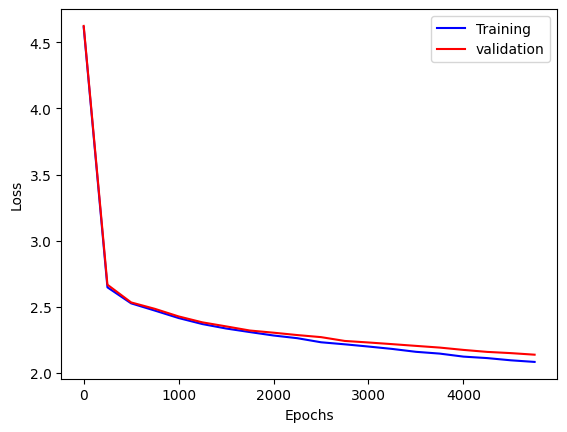

In [10]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import time
import random
import math

inf = torch.inf
context_length = 64 # No of tokens
model_dim = 64 # dimension of the model -> residual stream
n_layers = 2 # no of layers
n_heads = 0 # No of attention heads for layer # TODO
head_dim = 16
vocab_size = 65
learning_rate = 3e-4
max_iters = 5000
eval_iters = 100
batch_size = 32 #Takes 27k iters

lower_triangular_matrix = torch.tensor([[1 if i<=j else -torch.inf for i in range(context_length)] for j in range(context_length)]).float()

def tokenise(str: str):
    return torch.tensor([char_map[i] for i in str])

def decode(tokens: list[str]):
    return ''.join([reverse_char_map[i] for i in tokens])

file = open("tiny_shakesphere.txt", "r")
full_data = file.read()

vocab = list(sorted((set(full_data))))

char_map = {vocab[i]: i for i in range(len(vocab))}
reverse_char_map = {char_map[i] : i for i in char_map}
full_data = tokenise(full_data)

total_datapoints  = full_data.shape[0]

training_data : list[int] = full_data[:int(total_datapoints*0.9)]
validation_data = full_data[int(total_datapoints*0.9):total_datapoints]


def sample_data(split: str = "train"):
    data = training_data if split == 'train' else validation_data
    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = sample_data(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    
    return out["train"], out['val']


class Layer(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        

class AttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.key = nn.Linear(model_dim, head_dim)
        self.query = nn.Linear(model_dim, head_dim)
        self.value = nn.Linear(model_dim, head_dim)
        self.proj = nn.Linear(head_dim, model_dim)
    
    def forward(self, idx):
        key = self.key(idx) # (batch, context_length, head_dim)
        query = self.query(idx)
        value = self.value(idx) # (batch, context_length, head_dim)

        attention = (query@torch.transpose(key,1,2))/(math.sqrt(head_dim)) # (batch, context_length, context_length)

        attention = torch.tril(attention)

        attention = attention.masked_fill(attention == 0, -inf)

        attention = F.softmax(attention,-1) # probs along context_length sum to 1

        attention_value = attention@value  # (batch, context_length, head_dim)

        return self.proj(attention_value)  # (batch, context_length, model_dim)
    

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(model_dim, 4*model_dim), nn.Linear(4*model_dim, model_dim))
        self.relu = nn.ReLU()
    
    def forward(self, idx):
        logits = self.layers(idx)
        return self.relu(logits)

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, model_dim)
        self.pos_embedding = nn.Embedding(context_length, model_dim)
        self.attention_layes = nn.ModuleList([AttentionHead() for i in range(n_layers)])
        self.mlp_layers = nn.ModuleList([MLP() for i in range(n_layers)])
        self.unembed_layer = nn.Linear(model_dim,vocab_size)

        self.total_parameters = sum([p.numel() for p in self.parameters()])
        print(f"Model has {self.total_parameters//1000}k params")


    def forward(self, idx, targets = None):
        # idx -> [1,2,0,3..] (batch, context_length)

        # for p in range(idx.shape[0]):
        #     print([decode(idx[p].tolist()), decode(targets[p].tolist())])

        input_sequence_length = idx.shape[-1]

        residual_stream = self.token_embedding(idx)  # (batch, context_length, model_dim)
        residual_stream = residual_stream + self.pos_embedding(torch.tensor([i for i in range(input_sequence_length)])) # Pos embedding will be # (context_length, model_dim)
        
        for i in range(n_layers):
            residual_stream = residual_stream + self.attention_layes[i](residual_stream)
            residual_stream = residual_stream + self.mlp_layers[i](residual_stream)

        residual_stream = self.unembed_layer(residual_stream) # (batch, context_length, vocab_size)
        if targets is None:
            return residual_stream
        (x,y,z) = residual_stream.shape
        loss = F.cross_entropy(residual_stream.view(x*y,z), targets.view(x*y))
        return residual_stream, loss
    


model = Transformer()
train_loss,val_loss = estimate_loss()
print(f"Initial training loss: {train_loss}, val loss: {val_loss}")

loss_value = []
val_loss_value = []
iters = []
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
step_value = max_iters/20
start_time = time.time()
for iter in range(max_iters):
    X,Y= sample_data() # (B, context_length)
    logits, loss = model(X, Y)  # (B, context_length, vocab_size)
    if iter%step_value ==0:
        train_loss,val_loss = estimate_loss()
        iters.append(iter)
        loss_value.append(train_loss)
        val_loss_value.append(val_loss)
        print(f"iter:{iter} training loss: {train_loss}, val loss: {val_loss}")

    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()



        

In [11]:
def generate_text(input: str):
    max_tokens = 1000
    input_tokens = tokenise(input)
    print(input, end='')
    
    for i in range(max_tokens):
        now = model(input_tokens.unsqueeze(0))[0][-1]
        now = F.softmax(now, dim= 0)
        token = torch.multinomial(now,1).item()
        input_tokens = torch.tensor(input_tokens.tolist() + [token])
        text = decode([token])
        print(text, end='')
        input_tokens = input_tokens[-context_length:]
                

generate_text(" ")  

 and her's why Bretindsine in Soms wor the pron pave senrennearch wine this fone yeome meers. Evong goor of soams: has am nowe mmeske onqug swove tromine to be of ond thy ou leves,
Be nats ore I'd awe spexplend in arewer
Wherlly lougtins:
Stwir as the are fevoie merine 'do's famy goou to, spomerve kin thiss eve havad yoou oun gome oth har his dige, strash
hat and
Teme ut thean ste heant:
arw hore yous thar ne que deceantons? it mucing wil ta lleas al of oue bunt,
Onscenve.
ON no weren
sirupetce, I's a bed I wist forntseip thend her couse.

YGRUS:
No, pun:
I bue notedink, should 'd Pemorde?
Thon herelaman'd hat my have forwfort, orel wo',
Fwir, ssomp

Prir shy, Foud
Cay noth menor Romed, him hess tol, ance, wis kese keors heat:
Yimens thelateres, jedave

TI searn. Seen, I I heread natese; cerom,
Or yay.
ISiry.

dy liting, beish thalors bulind cou, you.
Whilerse in this nopengust
Lowht him.

AGRIO:
Re, Hasth the'd hor hou penem, fimen.

SENLIONCIUKINGHANDY:
Coplued what ally sadespu'd fl

In [8]:
generate_text(" ")  

 mind aveme ase fod,
Thames omend steetee'fitst in
Win, onors,
Bush,
Pow
T:
Ay ICyyctan,
Ther, ilt, I dound Nowad ly tharl chthe.
Whoncl'dkondrbe mins d;

I wandy buby arend mereroully ilad y peny,
Matoo
Lonl huril-DAUS:
Tod oviscer hon t seta wsow l owincen je m ay thealime
akniesh n; stulorou goterendss:
The ange tfl, wirondiko nd
Nou thapswhe m at cabeige bond, tyo wy lilil ostoicou vingr
ond woners be, thinde, the fphey my it, itotest I mp at ushy tit n brpabe
Bindipr co y:
There no cost sikotherok mosrived wirundenmeithin mis we be ves s prto,
Bule y ayowherlas,
I hive Mofod st s bllia m.
Anthy omer ay.
MTIICKIIN:
JAUCIICUCHONWIOTICED E:
A'TLIO:
DWh Ler downd w t, gy! matanofavenst th pma pe seamngrs tsfl, ome gesh ilard th soris ave itovenghawavorbur;
Th pp?

Ct, DICELD:
Fin,
Thor tilathon, PBunde s,
She Inke noorim wis amneapll trd f micolve hee?

ARDYOLES:
SUCw he hearesurser I dnd.
DUS:
Pothy thimer,
I'Toors bustt yousegengefe tt whthit awhodenr, youmt st Wout wamer mang d wor

In [22]:
a = tokenise("alik").unsqueeze(0)
output = model(a)
F.cross_entropy(output.resize(4,65), F.one_hot(tokenise("like").unsqueeze(0), vocab_size).resize(4, 65).float())

tensor(2.3337, grad_fn=<DivBackward1>)

torch.Size([1, 4, 65])